### Sobre os dados:

* **Esse conjunto de dados consiste em uma base de notas obtidas por alunos nas disciplinas matemática, leitura e escrita. Além desse atributos, há também outros como gênero do aluno, nível de escolaridade dos pais, etnia/raça dos alunos, etc.**

### Objetivo:

* **Promover a análise dos dados de educação, baixados da plataforma Kaggle, relacionando as diferentes características dos estudantes ao aplicar os conhecimentos de estatística descritiva (média, mediana, quartis, etc) e estatística inferencial (teste de normalidade e pós-hoc, quando necessário).**

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.weightstats as ws # Classe usada para aplicar o teste Z nas amostras com std's diferentes

# Testes de Normalidade
from scipy.stats import shapiro # Teste de Shapiro-Wilk
from scipy.stats import normaltest as DAgostino_Pearson # Teste de D’Agostinho-Pearson
from scipy.stats import anderson # Teste de Anderson-Darling
from scipy.stats import cramervonmises # Teste de Cramér-von Mises
from scipy.stats import kstest # Teste de Kolmogorov-Smirnov

# Teste de hipótese não-paramétrico
from scipy.stats import kruskal # Teste de Kruskal-Wallis - 2 ou mais amostras independentes
from scipy.stats import mannwhitneyu # Teste de Mann-Whitney - 2 amostras independentes

# Testes de hipótese paramétrico
from scipy.stats import f_oneway # Teste ANOVA 1 vía - 2 ou mais amostras independentes
from statsmodels.stats.weightstats import ztest, CompareMeans # Teste Z (2 formas de implementar) - 2 amostras independentes

# Teste pós-hoc
from statsmodels.stats.multicomp import MultiComparison # teste pós-hoc para o teste ANOVA 1 vía --> Teste de Tukey
from scikit_posthocs.sp import posthoc_nemenyi_friedman # teste pós-hoc para o teste kruskal --> Teste de Nemenyi

# Ignora alguns avisos
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Teste de normalidade - Shapiro-Wilk, D’Agostinho-Pearson, Anderson-Darling, Cramér-von Mises e Kolmogorov-Smirnov
# Nível de significância: alpha = 0.05
# H0 = Distribuição normal se p > alpha
# H1 = Distribuição != normal se p <= alpha

# Definindo um método para a execução de 5 testes de normalidade dos dados
def teste_normalidade(variables, alpha = 0.05):
    
    for v in variables:
        
        ######################################### Shapiro-Wilk ################################################################
            
        _, p_shapiro = shapiro(v)
            
        if p_shapiro > alpha:        
            print(f'Shapiro: p_value = {p_shapiro} - Distribuição normal')
            
        else:
            print(f'Shapiro: p_value = {p_shapiro} - Distribuição não-normal')
            
        ################################## Teste de D’Agostinho-Pearson #######################################################
        
        _, p_dagostinho = DAgostino_Pearson(v)
        
        if p_dagostinho > alpha:            
            print(f'D’Agostinho-Pearson: p_value = {p_dagostinho} - Distribuição normal')
            
        else:
            print(f'D’Agostinho-Pearson: p_value = {p_dagostinho} - Distribuição não-normal')            
        
            
        ####################################### Anderson-Darling ##############################################################
            
        ad_stat, ad_critical, _ = anderson(v, dist='norm')
        
        if alpha * 100 == 1.0:
            
            if ad_stat < ad_critical[4]:            
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} < ad_critical = {ad_critical[4]} - Distribuição normal')
                
            else:
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} >= ad_critical = {ad_critical[4]} - Distribuição não-normal')
                
        elif alpha * 100 == 2.5:
            
            if ad_stat < ad_critical[3]:            
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} < ad_critical = {ad_critical[3]} - Distribuição normal')
                
            else:
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} >= ad_critical = {ad_critical[3]} - Distribuição não-normal')
        
        
        elif alpha * 100 == 5.0:
            
            if ad_stat < ad_critical[2]:            
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} < ad_critical = {ad_critical[2]} - Distribuição normal')
                
            else:
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} >= ad_critical = {ad_critical[2]} - Distribuição não-normal')
                
        elif alpha * 100 == 10.0:
            
            if ad_stat < ad_critical[1]:            
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} < ad_critical = {ad_critical[1]} - Distribuição normal')
            
            else:
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} >= ad_critical = {ad_critical[1]} - Distribuição não-normal')
                
        elif alpha * 100 == 15.0:
            
            if ad_stat < ad_critical[0]:            
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} < ad_critical = {ad_critical[0]} - Distribuição normal')
                
            else:
                print(f'Anderson-Darling: ad_stat = {round(ad_stat, 3)} >= ad_critical = {ad_critical[0]} - Distribuição não-normal')
            
        ############################################# Cramér-von Mises ########################################################
            
        p_cramer = cramervonmises(v, 'norm').pvalue
            
        if p_cramer > alpha:        
            print(f'Cramér-von Mises: p_value = {p_cramer} - Distribuição normal')
        
        else:
            print(f'Cramér-von Mises: p_value = {p_cramer} - Distribuição não-normal')
        
            
       ############################################## Kolmogorov-Smirnov ######################################################

        _, p_k = kstest(v, 'norm')    
            
        if p_k > alpha:        
            print(f'Kolmogorov-Smirnov: p_value = {p_k} - Distribuição normal')
        
        else:
            print(f'Kolmogorov-Smirnov: p_value = {p_k} - Distribuição não-normal')
            
        print()

In [3]:
# Definindo um método para teste de hipótese
# H0 = Não há diferença estatística significativa nas médias entre os grupos; p > alpha
# H1 = Há diferença significativa na média entre os grupos; p <= alpha

def teste_hipotese(p, alpha = 0.05):
    
    if p <= alpha:        
        print(f'{p} <= {alpha} - Hipótese nula (H0) rejeitada')
        
    else:
        print(f'{p} > {alpha} - Hipótese alternativa (H1) rejeitada')

In [4]:
# Lê a Base de Dados
Base_Dados = pd.read_csv('StudentsPerformance.csv')

In [5]:
# Qntd de linhas e colunas (1000 linhas e 8 colunas)
Base_Dados.shape

(1000, 8)

In [6]:
# Exibe o nome das colunas
Base_Dados.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [7]:
# Qntd de valores distintos em cada coluna
Base_Dados.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

In [8]:
# Exibe os nomes das colunas, tipos de informação nas colunas, qntd de valores não nulos, memória para armazenamento dos dados e
# qntd de instâncias (entradas)
Base_Dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [9]:
# Soma quantos valores nulos há em cada coluna
Base_Dados.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [10]:
# Exibe as 5 primeiras linhas do dataframe
Base_Dados.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [11]:
# Análise descritiva dos dados
Base_Dados.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Pode-se verificar que as notas mínimas e máximas para cada teste foram

* Matemática: nota mínima = 0; nota máxima = 100;

* Leitura: nota mínima = 17; nota máxima = 100;

* Escrita: nota mínima = 10; nota máxima = 100.

Seguindo com a análise, verifica-se que

* Matemática: 25% dos alunos conseguiram nota de até 57 pontos; 50% dos alunos conseguiram até 66 pontos; 75% dos alunos conseguiram até 77 pontos;

* Leitura: 25% dos alunos conseguiram nota de até 59 pontos; 50% dos alunos conseguiram até 70 pontos; 75% dos alunos conseguiram até 79 pontos;

* Escrita: 25% dos alunos conseguiram nota de até 57,75 pontos; 50% dos alunos conseguiram até 69 pontos; 75% dos alunos conseguiram até 79 pontos.

A média e o desvio padrão ("erro" ou "incerteza") são

* Matemática: 66.089 +- 15.163;
* Leitura: 69.169 +- 14.600;
* Escrita: 68.054 +- 15.196.

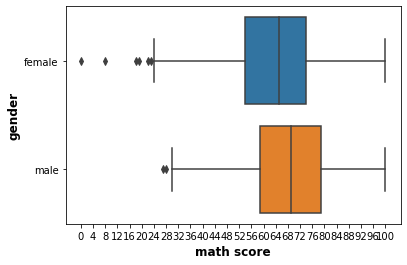

In [12]:
# Gráfico de boxplot para comparar as notas de matemática entre os diferentes sexos
sns.boxplot(data=Base_Dados, x='math score', y='gender')
plt.ylabel('gender', fontsize = 12, fontweight = 'bold')
plt.xlabel('math score', fontsize = 12, fontweight = 'bold')
plt.xticks(range(0, 104, 4));

Observa-se que

* alguns _outliers_ estão presentes nas bases de dados de matemática;
* a nota mínima dos alunos é ligeiramente maior que a das alunas;
* a mediana das notas dos alunos é ligeiramente maior que a das alunas.

Para verificar se essa diferença entre as notas é estatísticamente significativa, é necessário a execução de um teste de normalidade para, após isso, efetuar um teste de hipótese estatístico apropriado.

**Alguns tratamento dos dados serão feitos, como**

* Exclusão dos *outliers* das notas de matemática das alunas e dos alunos;
* Igualar a quantidade de valores de entrada (notas) de matemática das alunas com a quantidade pertencente aos alunos;
* Gerar 2 novos *boxplots* para verificar se ainda existem *outliers* nas bases de dados de matematica dos alunos e alunas.

In [13]:
# Separação das notas de matemática pelo sexo e exclusão de outliers
female_math = Base_Dados[Base_Dados['gender'] == 'female']['math score']
female_math = female_math[female_math > 24] # exclui outliers - exclui valores abaixo de 24

male_math = Base_Dados[Base_Dados['gender'] == 'male']['math score']
male_math = male_math[male_math > 30] # exclui outliers - exclui valores abaixo de 30

In [14]:
# Estatística descritiva das notas de matemática dos alunos --> count = 478
male_math.describe()

count    478.000000
mean      69.062762
std       13.939230
min       35.000000
25%       59.000000
50%       69.000000
75%       79.000000
max      100.000000
Name: math score, dtype: float64

In [15]:
# Estatística descritiva das notas de matemática das alunas --> count = 511
female_math.describe()

count    511.000000
mean      64.281800
std       14.530794
min       26.000000
25%       54.000000
50%       65.000000
75%       74.000000
max      100.000000
Name: math score, dtype: float64

In [16]:
# Iguala a qntd de notas das alunas com a qntd de notas dos alunos
female_math = female_math.sample(n = len(male_math), random_state = 0)

In [17]:
# Estatística descritiva dos dados de matemática das alunas --> count = 478, igual ao count dos alunos.
female_math.describe()

count    478.000000
mean      64.449791
std       14.605238
min       26.000000
25%       54.000000
50%       65.000000
75%       74.000000
max      100.000000
Name: math score, dtype: float64

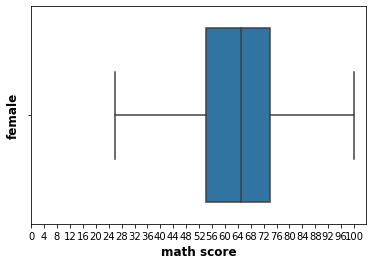

In [18]:
# Gráfico de boxplot das notas de matemática das alunas - sem outliers
sns.boxplot(data = female_math, x = female_math.values)
plt.ylabel('female', fontsize = 12, fontweight = 'bold')
plt.xlabel('math score', fontsize = 12, fontweight = 'bold')
plt.xticks(range(0, 104, 4));

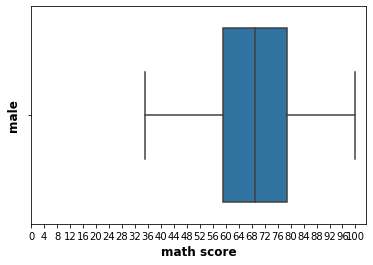

In [19]:
# Gráfico de boxplot das notas de matemática dos alunos - sem outliers
sns.boxplot(data = male_math, x = male_math.values)
plt.ylabel('male', fontsize = 12, fontweight = 'bold')
plt.xlabel('math score', fontsize = 12, fontweight = 'bold')
plt.xticks(range(0, 104, 4));

In [20]:
# Cria um objeto para armazenar as variáveis com as notas de matemática tratadas
variables = [female_math, male_math]

In [21]:
# Efetua o teste de normalidade para as notas de matemática das alunas e para as notas de matemática dos alunos, respec.
teste_normalidade(variables)

Shapiro: p_value = 0.2548423707485199 - Distribuição normal
D’Agostinho-Pearson: p_value = 0.5080394855396844 - Distribuição normal
Anderson-Darling: ad_stat = 0.341 < ad_critical = 0.781 - Distribuição normal
Cramér-von Mises: p_value = 0 - Distribuição não-normal
Kolmogorov-Smirnov: p_value = 0.0 - Distribuição não-normal

Shapiro: p_value = 0.010235482826828957 - Distribuição não-normal
D’Agostinho-Pearson: p_value = 0.0010188115695083056 - Distribuição não-normal
Anderson-Darling: ad_stat = 0.711 < ad_critical = 0.781 - Distribuição normal
Cramér-von Mises: p_value = 0 - Distribuição não-normal
Kolmogorov-Smirnov: p_value = 0.0 - Distribuição não-normal



Verifica-se que, de acordo com os testes de normalidade executados, os registros para as notas de matemática das alunas apresentam uma distribuição normal.<br>

Já os registros para as notas de matemática dos alunos **<font color='red'>não</font>** seguem uma distribuição normal.<br>

Aplica-se, a seguir, o teste não-paramétrico de Mann-Whitney para saber se há diferença estatística significativa entre as medianas das notas de matemática dos alunos e alunas.

In [22]:
# Teste não-paramétrico - Mann-Whitney
_, p_mann = mannwhitneyu(female_math, male_math)
print(f'pvalue: {p_mann}')

pvalue: 2.587938440726114e-06


In [23]:
# A título de curiosidade, aplicou-se o teste paramétrico Z

# Aplica o teste z, considerando os desvios padrões de x1 e x2 iguais
_, p_ztest_1 = ztest(female_math, male_math,
             alternative='two-sided')
print(f'pvalue_std_iguais: {p_ztest_1}')
print()

# Aplica o teste z, considerando os desvios padrões de x1 e x2 diferentes
v1 = ws.DescrStatsW(male_math)
v2 = ws.DescrStatsW(female_math)
_, p_ztest_2 = ws.CompareMeans(v1,v2).ztest_ind(alternative='two-sided', usevar='unequal')
print(f'pvalue_std_diferentes: {p_ztest_2}')

pvalue_std_iguais: 5.871662486253051e-07

pvalue_std_diferentes: 5.871662486253051e-07


In [24]:
# Verificação dos testes de hipótese:

# H0 = Não há diferença estatística significativa entre as medianas dos grupos
# H1 = Há diferença estatística significativa entre as medianas dos grupos
# se p <= alpha: H0 rejeitada; p > alpha: H1 rejeitada. 
teste_hipotese(p_mann)
teste_hipotese(p_ztest_2)

2.587938440726114e-06 <= 0.05 - Hipótese nula (H0) rejeitada
5.871662486253051e-07 <= 0.05 - Hipótese nula (H0) rejeitada


Após a execução dos testes de normalidade nas notas de matemática para alunos e alunas, aplicou-se o teste não-paramétrico de Mann-Whitney aos dados (para 2 amostras independentes) que gerou um p-value menor que alpha = 0.05 e, portanto, as medianas das notas de matemática para os alunos e para alunas apresentam uma diferença estatística significativa com 95% de confiança. 

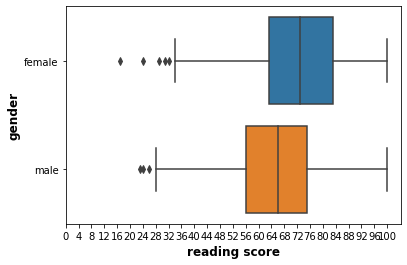

In [25]:
# Gráfico de boxplot para comparar as notas de leitura entre os diferentes sexos
sns.boxplot(data=Base_Dados, x='reading score', y='gender')
plt.ylabel('gender', fontsize = 12, fontweight = 'bold')
plt.xlabel('reading score', fontsize = 12, fontweight = 'bold')
plt.xticks(range(0, 103, 4));

Observa-se que

* alguns _outliers_ estão presentes nas bases de dados;
* a nota mínima das alunas é ligeiramente maior que a dos alunos;
* A mediana das notas das alunas é ligeiramente maior que a dos alunos.

Para verificar se essa diferença entre as notas é estatísticamente significativa, é necessário a execução de um teste de normalidade para, após isso, efetuar um teste de hipótese estatístico apropriado.

**Alguns tratamento dos dados serão feitos, como**

* Exclusão dos *outliers* das notas de leitura das alunas e dos alunos;
* Igualar a quantidade de valores de entrada (notas) de leitura das alunas com a quantidade pertencente aos alunos;
* Gerar 2 novos *boxplots* para verificar se ainda existem *outliers* nas bases de dados de leitura dos alunos e alunas.

In [26]:
# Separação das notas de leitura pelo sexo e exclusão de outliers
female_read = Base_Dados[Base_Dados['gender'] == 'female']['reading score']
female_read = female_read[female_read > 34] # retira outliers - exclui valores abaixo de 34

male_read = Base_Dados[Base_Dados['gender'] == 'male']['reading score']
male_read = male_read[male_read > 28] # retira outliers - exclui valores abaixo de 28

In [27]:
# Estatística descritiva das notas de leitura dos alunos --> count = 478
male_read.describe()

count    478.000000
mean      65.809623
std       13.491179
min       29.000000
25%       56.000000
50%       66.000000
75%       75.000000
max      100.000000
Name: reading score, dtype: float64

In [28]:
# Estatística descritiva das notas de leitura das alunas --> count = 511
female_read.describe()

count    511.000000
mean      73.209393
std       13.502258
min       38.000000
25%       64.000000
50%       73.000000
75%       83.000000
max      100.000000
Name: reading score, dtype: float64

In [29]:
# Iguala a qntd de notas das alunas com a qntd de notas dos alunos
female_read = female_read.sample(n = len(male_read), random_state = 0)

In [30]:
# Estatística descritiva dos dados de leitura das alunas --> count = 478, igual ao count dos alunos.
female_read.describe()

count    478.000000
mean      73.271967
std       13.482549
min       38.000000
25%       64.000000
50%       74.000000
75%       83.000000
max      100.000000
Name: reading score, dtype: float64

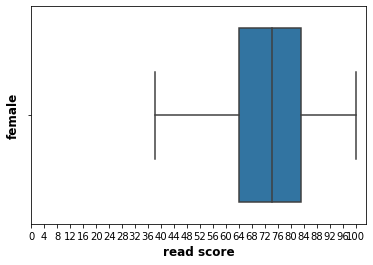

In [31]:
# Gráfico de boxplot das notas de leitura das alunas - sem outliers
sns.boxplot(data = female_read, x = female_read.values)
plt.ylabel('female', fontsize = 12, fontweight = 'bold')
plt.xlabel('read score', fontsize = 12, fontweight = 'bold')
plt.xticks(range(0, 104, 4));

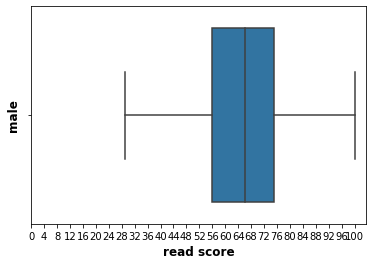

In [32]:
# Gráfico de boxplot das notas de leitura dos alunos - sem outliers
sns.boxplot(data = male_read, x = male_read.values)
plt.ylabel('male', fontsize = 12, fontweight = 'bold')
plt.xlabel('read score', fontsize = 12, fontweight = 'bold')
plt.xticks(range(0, 104, 4));

In [33]:
# Cria um objeto para armazenar as variáveis com as notas de leitura tratadas
variables = [female_read, male_read]

In [34]:
# Efetua o teste de normalidade para as notas de leitura das alunas e dos alunos, respec.
teste_normalidade(variables)

Shapiro: p_value = 0.0033574916888028383 - Distribuição não-normal
D’Agostinho-Pearson: p_value = 0.038993944969424474 - Distribuição não-normal
Anderson-Darling: ad_stat = 0.617 < ad_critical = 0.781 - Distribuição normal
Cramér-von Mises: p_value = 0 - Distribuição não-normal
Kolmogorov-Smirnov: p_value = 0.0 - Distribuição não-normal

Shapiro: p_value = 0.0847172960639 - Distribuição normal
D’Agostinho-Pearson: p_value = 0.02889408280286129 - Distribuição não-normal
Anderson-Darling: ad_stat = 0.739 < ad_critical = 0.781 - Distribuição normal
Cramér-von Mises: p_value = 0 - Distribuição não-normal
Kolmogorov-Smirnov: p_value = 0.0 - Distribuição não-normal



Verifica-se, que de acordo com os testes de normalidade executados, os registros para as notas de leitura das alunas e dos alunos **<font color='red'>não</font>** seguem uma distribuição normal.<br>

Aplica-se, a seguir, o teste não-paramétrico de Mann-Whitney para saber se há diferença estatística significativa entre as medianas das notas de leitura dos alunos e alunas.

In [35]:
# Teste não-paramétrico - Mann-Whitney
_, p = mannwhitneyu(female_read, male_read)
print(f'pvalue: {p}')

pvalue: 6.688539932861767e-16


In [36]:
# Verificação do teste de hipótese:

# H0 = Não há diferença significativa entre as medianas entre os grupos
# H1 = Há diferença significativa entre as medianas entre os grupos
# se p <= alpha: H0 rejeitada; p > alpha: H1 rejeitada. 
teste_hipotese(p)

6.688539932861767e-16 <= 0.05 - Hipótese nula (H0) rejeitada


Após a execução dos testes de normalidade nas notas de leitura para alunos e alunas, aplicou-se o teste não-paramétrico de Mann-Whitney aos dados (para 2 amostras independentes) que gerou um p-value menor que alpha = 0.05 e, portanto, as medianas das notas de leitura para os alunos e para alunas apresentam uma diferença estatística significativa com 95% de confiança. 

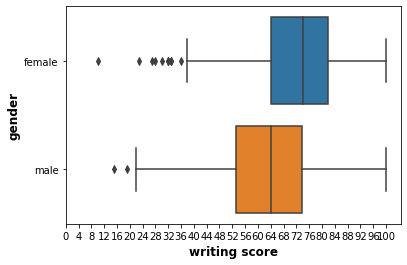

In [37]:
# Gráfico de boxplot para comparar as notas de escrita entre os diferentes sexos
sns.boxplot(data=Base_Dados, x='writing score', y='gender')
plt.ylabel('gender', fontsize = 12, fontweight = 'bold')
plt.xlabel('writing score', fontsize = 12, fontweight = 'bold')
plt.xticks(range(0, 103, 4));

Observa-se que

* alguns _outliers_ estão presentes nas bases de dados;
* a nota mínima das alunas é maior que a dos alunos;
* A mediana das notas das alunas é maior que a dos alunos.

Para verificar se essa diferença entre as notas é estatísticamente significativa, é necessário a execução de um teste de normalidade para, após isso, efetuar um teste de hipótese estatístico apropriado.

**Alguns tratamento dos dados serão feitos, como**

* Exclusão dos *outliers* das notas de escrita das alunas e dos alunos;
* Igualar a quantidade de valores de entrada (notas) de escrita das alunas com a quantidade pertencente aos alunos;
* Gerar 2 novos *boxplots* para verificar se ainda existem *outliers* nas bases de dados de escrita dos alunos e alunas.

In [38]:
# Separação das notas de escrita pelo sexo e exclusão de outliers
female_writ = Base_Dados[Base_Dados['gender'] == 'female']['writing score']
female_writ = female_writ[female_writ > 39] # retira outliers - exclui valores abaixo de 39

male_writ = Base_Dados[Base_Dados['gender'] == 'male']['writing score']
male_writ = male_writ[male_writ > 22] # retira outliers - exclui valores abaixo de 22

In [39]:
# Estatística descritiva das notas de escrita dos alunos --> count = 479
male_writ.describe()

count    479.000000
mean      63.590814
std       13.704426
min       27.000000
25%       53.000000
50%       64.000000
75%       74.000000
max      100.000000
Name: writing score, dtype: float64

In [40]:
# Estatística descritiva das notas de escrita das alunas --> count = 504
female_writ.describe()

count    504.000000
mean      73.613095
std       13.276952
min       40.000000
25%       65.000000
50%       74.000000
75%       82.000000
max      100.000000
Name: writing score, dtype: float64

In [41]:
# Estatística descritiva dos dados de leitura das alunas --> count = 479, igual ao count dos alunos.
female_writ = female_writ.sample(n = len(male_writ), random_state = 0)

In [42]:
# Estatística descritiva das notas de escrita das alunas --> count = 479
female_writ.describe()

count    479.000000
mean      73.519833
std       13.280019
min       40.000000
25%       65.000000
50%       74.000000
75%       82.000000
max      100.000000
Name: writing score, dtype: float64

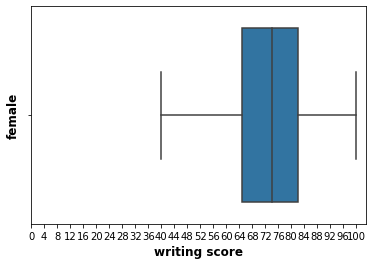

In [43]:
# Gráfico de boxplot das notas de escrita das alunas - sem outliers
sns.boxplot(data = female_writ, x = female_writ.values)
plt.ylabel('female', fontsize = 12, fontweight = 'bold')
plt.xlabel('writing score', fontsize = 12, fontweight = 'bold')
plt.xticks(range(0, 103, 4));

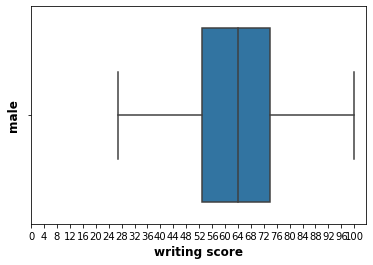

In [44]:
# Gráfico de boxplot das notas de escrita dos alunos - sem outliers
sns.boxplot(data = male_writ, x = male_writ.values)
plt.ylabel('male', fontsize = 12, fontweight = 'bold')
plt.xlabel('writing score', fontsize = 12, fontweight = 'bold')
plt.xticks(range(0, 103, 4));

In [45]:
# Cria um objeto para armazenar as variáveis com as notas de escrita tratadas
variables = [female_writ, male_writ]

In [46]:
# Efetua o teste de normalidade para as notas de escrita das alunas e dos alunos, respec.
teste_normalidade(variables)

Shapiro: p_value = 0.0014401428634300828 - Distribuição não-normal
D’Agostinho-Pearson: p_value = 0.016740991603081356 - Distribuição não-normal
Anderson-Darling: ad_stat = 0.804 >= ad_critical = 0.781 - Distribuição não-normal
Cramér-von Mises: p_value = 0 - Distribuição não-normal
Kolmogorov-Smirnov: p_value = 0.0 - Distribuição não-normal

Shapiro: p_value = 0.06020838022232056 - Distribuição normal
D’Agostinho-Pearson: p_value = 0.008070682068242041 - Distribuição não-normal
Anderson-Darling: ad_stat = 0.794 >= ad_critical = 0.781 - Distribuição não-normal
Cramér-von Mises: p_value = 0 - Distribuição não-normal
Kolmogorov-Smirnov: p_value = 0.0 - Distribuição não-normal



Verifica-se que, de acordo com os testes de normalidade executados, os registros para as notas de escrita das alunas e dos alunos **<font color='red'>não</font>** seguem uma distribuição normal.<br>

Aplica-se, a seguir, o teste não-paramétrico de Mann-Whitney para saber se há diferença estatística significativa entre as medianas das notas de escrita dos alunos e alunas.

In [47]:
# Teste não-paramétrico - Mann-Whitney
_, p = mannwhitneyu(female_writ, male_writ)
print(f'pvalue: {p}')

pvalue: 7.771611248390053e-26


In [48]:
# Verificação do teste de hipótese:

# H0 = Não há diferença significativa entre as medianas entre os grupos
# H1 = Há diferença significativa entre as medianas entre os grupos
# se p <= alpha: H0 rejeitada; p > alpha: H1 rejeitada. 
teste_hipotese(p)

7.771611248390053e-26 <= 0.05 - Hipótese nula (H0) rejeitada


Após a execução dos testes de normalidade nas notas de escrita para alunos e alunas, aplicou-se o teste não-paramétrico de Mann-Whitney aos dados (para 2 amostras independentes) que gerou um p-value menor que alpha (0.05) e, portanto, as medianas das notas de escrita para os alunos e alunas apresentam uma diferença estatística significativa com 95% de confiança. 

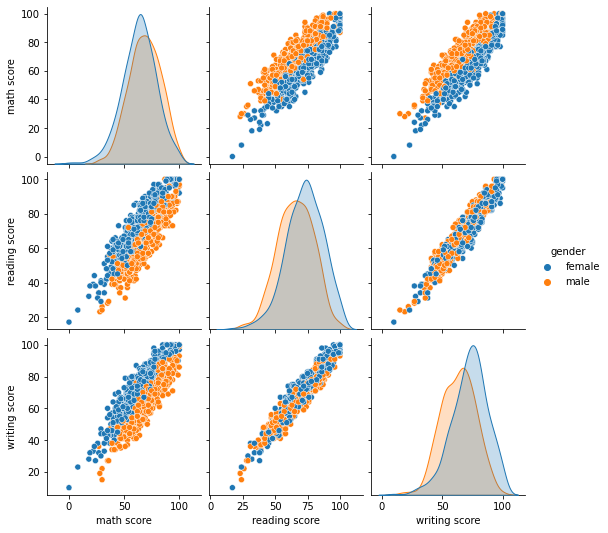

In [49]:
# Outra forma de avaliar as notas entre os alunos e alunas, além do uso do boxplot

# Comparação entre os atributos (colunas), com os dados separados por sexo
sns.pairplot(Base_Dados, hue='gender');

In [50]:
Base_Dados.corr()

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


<img src="Apresentação1.png" width=300px  style="float: left">

Pelo deslocamento (para a direita ou para a esquerda) da reta que poderia ser ajustada a cada um dos grupos de dados apresentados (bolinhas azuis - feminino e bolinhas amarelas - masculino), há uma relação clara entre as notas de **<font color='blue'>matemática</font>** & **<font color='green'>escrita</font>** e **<font color='blue'>matemática</font>** & **<font color='orange'>leitura</font>** dos alunos quando separadas por sexo:

* Alunas: as notas de matemática são mais baixas que as de escrita
* Alunas: as notas de matemática são mais baixas que as de leitura
<br><br>
* Alunos: as notas de matemática são melhores que as de escrita
* Alunos: as notas de matemática são melhores que as de leitura

Pelas altas correlações positivas, pode-se dizer que quem consegue notas altas (baixas) em uma determinada disciplina, consegue notas altas (baixas) nas outras disciplinas também.

In [51]:
# Separação das notas de matemática por raça/etnia
Base_Dados_A = Base_Dados[(Base_Dados['race/ethnicity'] == 'group A')]['math score'].reset_index(drop = True)
Base_Dados_B = Base_Dados[(Base_Dados['race/ethnicity'] == 'group B')]['math score'].reset_index(drop = True)
Base_Dados_C = Base_Dados[(Base_Dados['race/ethnicity'] == 'group C')]['math score'].reset_index(drop = True)
Base_Dados_D = Base_Dados[(Base_Dados['race/ethnicity'] == 'group D')]['math score'].reset_index(drop = True)
Base_Dados_E = Base_Dados[(Base_Dados['race/ethnicity'] == 'group E')]['math score'].reset_index(drop = True)

# Armazena as series de dados em um dicionário
dados = {'group A':Base_Dados_A, 'group B':Base_Dados_B, 'group C':Base_Dados_C, 'group D':Base_Dados_D, 'group E':Base_Dados_E}

# Cria um dataframne com as series ajustadas
Base_Dados_etnia = pd.DataFrame(data = dados).reset_index(drop = True)

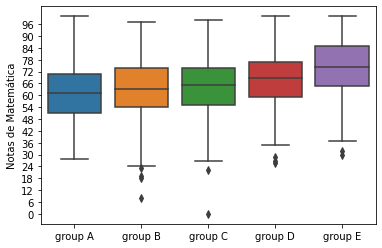

In [52]:
# Gráfico de boxplot para comparar as notas de matemática entre as diferentes raças/etnias
sns.boxplot(data=Base_Dados_etnia)
plt.ylabel('Notas de Matemática')
plt.yticks(range(0, 100, 6));

In [53]:
# Exclusão de outliers da base de dados de matemática (notas) separados por raça/etnia
Base_Dados_A_sem_outliers = Base_Dados_A

Base_Dados_B_sem_outliers = Base_Dados_B[Base_Dados_B > 24] # retira outliers - exclui valores abaixo de 24

Base_Dados_C_sem_outliers = Base_Dados_C[Base_Dados_C > 26] # retira outliers - exclui valores abaixo de 26

Base_Dados_D_sem_outliers = Base_Dados_D[Base_Dados_D > 34] # retira outliers - exclui valores abaixo de 34

Base_Dados_E_sem_outliers = Base_Dados_E[Base_Dados_E > 36] # retira outliers - exclui valores abaixo de 36

# Armazena, em um dicionário, as séries de dados sem outliers
dados_sem_outliers = {'group A':Base_Dados_A_sem_outliers, 'group B':Base_Dados_B_sem_outliers, 
                      'group C':Base_Dados_C_sem_outliers, 'group D':Base_Dados_D_sem_outliers, 
                      'group E':Base_Dados_E_sem_outliers}

# Cria um dataframne com as séries
Base_Dados_etnia_sem_outliers = pd.DataFrame(data = dados_sem_outliers).reset_index(drop = True)

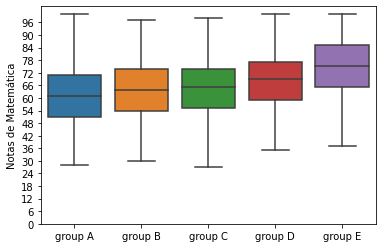

In [54]:
# Gráfico de boxplot para comparar as notas de matemática entre as diferentes raças/etnias- sem outliers
sns.boxplot(data=Base_Dados_etnia_sem_outliers)
plt.ylabel('Notas de Matemática')
plt.yticks(range(0, 100, 6));

In [55]:
# Análise descritiva da nova série de dados
Base_Dados_etnia_sem_outliers.describe()

,group A,group B,group C,group D,group E
count,89.000000,185.000000,317.000000,259.000000,138.000000
mean,61.629213,64.670270,64.801262,67.826255,74.442029
std,14.523008,13.720202,14.248749,13.150468,14.753457
min,28.000000,30.000000,27.000000,35.000000,37.000000
25%,51.000000,54.000000,55.000000,59.000000,65.250000
50%,61.000000,64.000000,65.000000,69.000000,75.000000
75%,71.000000,74.000000,74.000000,77.000000,85.000000
max,100.000000,97.000000,98.000000,100.000000,100.000000


In [56]:
# Séries de dados sem outliers para testar a normalidade
variables = [Base_Dados_A_sem_outliers, Base_Dados_B_sem_outliers, Base_Dados_C_sem_outliers, Base_Dados_D_sem_outliers, 
             Base_Dados_E_sem_outliers]

# Efetuando o teste de normalidade
teste_normalidade(variables)

Shapiro: p_value = 0.8545348644256592 - Distribuição normal
D’Agostinho-Pearson: p_value = 0.5154095093796678 - Distribuição normal
Anderson-Darling: ad_stat = 0.199 < ad_critical = 0.755 - Distribuição normal
Cramér-von Mises: p_value = 0 - Distribuição não-normal
Kolmogorov-Smirnov: p_value = 0.0 - Distribuição não-normal

Shapiro: p_value = 0.45818397402763367 - Distribuição normal
D’Agostinho-Pearson: p_value = 0.4019564859347987 - Distribuição normal
Anderson-Darling: ad_stat = 0.349 < ad_critical = 0.771 - Distribuição normal
Cramér-von Mises: p_value = 0 - Distribuição não-normal
Kolmogorov-Smirnov: p_value = 0.0 - Distribuição não-normal

Shapiro: p_value = 0.31851834058761597 - Distribuição normal
D’Agostinho-Pearson: p_value = 0.8205947484516929 - Distribuição normal
Anderson-Darling: ad_stat = 0.345 < ad_critical = 0.777 - Distribuição normal
Cramér-von Mises: p_value = 1.9106171755822743e-08 - Distribuição não-normal
Kolmogorov-Smirnov: p_value = 0.0 - Distribuição não-norm

Verifica-se que, de acordo com os testes de normalidade executados, os registros para as notas de matemática de todos os alunos, separados por grupos de raça/etnia, apresentam uma distribuição normal.

In [57]:
# Aplicação do teste paramétrico ANOVA de 1 via (2 ou mais amostras independentes)
_, p_anova = f_oneway(Base_Dados_A_sem_outliers, Base_Dados_B_sem_outliers, Base_Dados_C_sem_outliers, 
                       Base_Dados_D_sem_outliers, Base_Dados_E_sem_outliers)
print(p_anova)

5.277703209843429e-13


In [58]:
# Verificação do teste de hipótese:

# H0 = Não há diferença significativa entre as medianas entre os grupos
# H1 = Há diferença significativa entre as medianas entre os grupos
# se p <= alpha: H0 rejeitada; p > alpha: H1 rejeitada. 
teste_hipotese(p_anova)

5.277703209843429e-13 <= 0.05 - Hipótese nula (H0) rejeitada


In [59]:
# Preparação dos dados para o teste pós-hoc de Tukey

# Junta as séries de dados tratados - sem outliers
valores_grupo = np.concatenate((Base_Dados_A_sem_outliers, Base_Dados_B_sem_outliers, Base_Dados_C_sem_outliers, 
                                Base_Dados_D_sem_outliers, Base_Dados_E_sem_outliers))

# Forma listas (grupo1, grupo2 e grupo3) de strings repetidas
grupo1 = ["Base_Dados_A_sem_outliers"] * len(Base_Dados_A_sem_outliers) + ["Base_Dados_B_sem_outliers"] * len(Base_Dados_B_sem_outliers)
grupo2 = ["Base_Dados_C_sem_outliers"] * len(Base_Dados_C_sem_outliers) + ["Base_Dados_D_sem_outliers"] * len(Base_Dados_D_sem_outliers)
grupo3 = ["Base_Dados_E_sem_outliers"] * len(Base_Dados_E_sem_outliers)
grupo = grupo1 + grupo2 + grupo3 # Junta as listas em uma única lista

# Atribui os valores de cada série de dados as strings que correspondem as séries de dados aos quais os valores pertencem.
dados = {'valores_grupo': valores_grupo, 'grupo': grupo}
Base_Dados_etnia_reconfig = pd.DataFrame(dados) # Cria um dataframe, usando o dicionário dados
Base_Dados_etnia_reconfig

,valores_grupo,grupo
0,47,Base_Dados_A_sem_outliers
1,78,Base_Dados_A_sem_outliers
2,50,Base_Dados_A_sem_outliers
3,73,Base_Dados_A_sem_outliers
4,55,Base_Dados_A_sem_outliers
...,...,...
983,100,Base_Dados_E_sem_outliers
984,68,Base_Dados_E_sem_outliers
985,81,Base_Dados_E_sem_outliers
986,86,Base_Dados_E_sem_outliers


In [60]:
# Configuração e instanciação do algoritmo usado para comparação entre os grupos - Teste de Tukey
compara_grupos = MultiComparison(Base_Dados_etnia_reconfig['valores_grupo'], Base_Dados_etnia_reconfig['grupo'])

In [61]:
# Aplicação do teste de Tukey
teste_tukey = compara_grupos.tukeyhsd()
print(teste_tukey)

                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
Base_Dados_A_sem_outliers Base_Dados_B_sem_outliers   3.0411  0.442 -1.8833  7.9654  False
Base_Dados_A_sem_outliers Base_Dados_C_sem_outliers    3.172 0.3217 -1.4072  7.7513  False
Base_Dados_A_sem_outliers Base_Dados_D_sem_outliers    6.197  0.003  1.5068 10.8873   True
Base_Dados_A_sem_outliers Base_Dados_E_sem_outliers  12.8128    0.0  7.6232 18.0024   True
Base_Dados_B_sem_outliers Base_Dados_C_sem_outliers    0.131    1.0 -3.4008  3.6627  False
Base_Dados_B_sem_outliers Base_Dados_D_sem_outliers    3.156 0.1311 -0.5186  6.8306  False
Base_Dados_B_sem_outliers Base_Dados_E_sem_outliers   9.7718    0.0  5.4781 14.0654   True
Base_Dados_C_sem_outliers Base_Dados_D_sem_outliers    3.025 0.0738 -0.1723  6.2223  False

Após a execução dos testes de normalidade nas notas de matemática para todos os grupos, o teste ANOVA de 1 vía indicou uma diferença estatística significativa entre as médias dos grupos com 95% de confiança. O teste pós-hoc de tukey serviu para indicar entre quais grupos específicos havia uma diferença estatística significativa (ou não) entre as médias. Esse teste gerou um p-value menor que alpha = 0.05 para as médias entre os grupos <font color='red'>**A**</font> e <font color='red'>**D**</font>, <font color='red'>**A**</font> e <font color='red'>**E**</font>, <font color='red'>**B**</font> e <font color='red'>**E**</font>, <font color='red'>**C**</font> e <font color='red'>**E**</font> e <font color='red'>**D**</font> e <font color='red'>**E**</font>. Portanto, as médias das notas de matemática entre esses grupos citados apresentam uma diferença estatística significativa com 95% de confiança. 

In [62]:
# Agrupa os dados por curso preparatório (fez ou não fez) e retorna apenas a estatística descritiva das notas de matemática
Base_Dados.groupby( by=['test preparation course']).describe()['math score'].reset_index()

,test preparation course,count,mean,std,min,25%,50%,75%,max
0,completed,358.0,69.695531,14.444699,23.0,60.0,69.0,79.00,100.0
1,none,642.0,64.077882,15.192376,0.0,54.0,64.0,74.75,100.0


**De forma geral, quem fez curso preparatório obtém notas melhores em matemática do que aqueles que não fizeram curso preparatório.**

In [63]:
# Agrupa os dados por nivel de formação dos pais e retorna apenas a estatística descritiva das notas de matemática
Base_Dados.groupby(by=['parental level of education']).describe()['math score'].reset_index().sort_values(by=['50%'], 
                                                                                                          ascending=False)

,parental level of education,count,mean,std,min,25%,50%,75%,max
3,master's degree,59.0,69.745763,15.153915,40.0,55.50,73.0,81.0,95.0
1,bachelor's degree,118.0,69.389831,14.943789,29.0,61.00,68.0,79.0,100.0
4,some college,226.0,67.128319,14.312897,19.0,59.00,67.5,76.0,100.0
0,associate's degree,222.0,67.882883,15.112093,26.0,57.00,67.0,80.0,100.0
5,some high school,179.0,63.497207,15.927989,0.0,53.00,65.0,74.0,97.0
2,high school,196.0,62.137755,14.539651,8.0,53.75,63.0,72.0,99.0


**De forma geral, segundo os dados, aqueles que tem pais com nível de educação mais alto costumam apresentar melhor desempenho nas notas de matemática quando comparados aqueles que tem pais com nível de educação mais baixo.**